# Off-peak analysis

We first read the CSV files that were exported from merging traffic and demand data. Two files are produced, one for actual times (without cancelled trips) and one for planned time (larger file).

In [1]:
import pandas as pd

# Read the CSV file
#df_onboard_planned = pd.read_csv('df_onboard_planned.csv') ### passenger onboard estimated using PLANNED departure times
df_onboard_actual = pd.read_csv('df_onboard_actual.csv') ## passenger onboard estimated using ACTUAL departure times

We want to study passenger punctuality using different metrics during off-peak time period of the day (9-15).

### Filtering data (oustide off-peak)

Let us first filter out the observations outside middday off-peak hours. We remove all trains that first departure outside these hours.

In [2]:
# Define the time range in terms of 'dep_t_float'
earliest_time = 9 * 4  # 9 AM, 36
latest_time = 15 * 4   # 3 PM, 60

# Step 1: Group the data by 'Datum', 'Taguppdrag', 'Tagnr'
grouped_actual = df_onboard_actual.groupby(['Datum', 'Taguppdrag', 'Tagnr'])

# Step 2: Filter out groups based on the first departure time
def filter_by_departure_time(group):
    # Get the first departure's dep_t_float value
    first_dep = group[group['UppehallstypAvgang'] == 'Första']['dep_t_float']
    
    # Check if the first departure exists and is within the specified range
    if not first_dep.empty:
        first_dep_time = first_dep.iloc[0]
        return earliest_time <= first_dep_time <= latest_time
    
    # If no 'Första' is found, exclude the group
    return False

# Step 3: Filter the original DataFrame to keep only the groups that match the condition
df_onboard_actual_offpeak = grouped_actual.filter(filter_by_departure_time).reset_index(drop=True)

### Average train ridership per direction

Let us plot the average train ridership between consecutive station per direction.

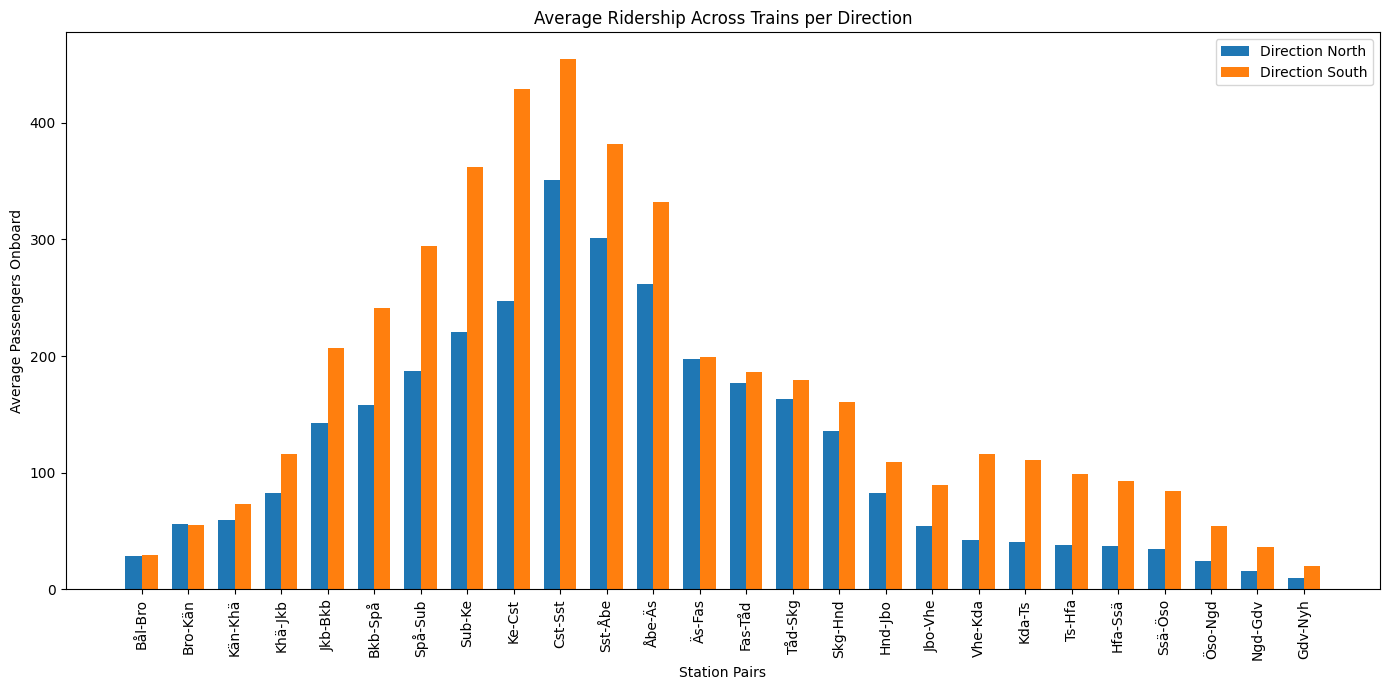

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_ridership(df):
    # List of stations from north to south
    stations_north_to_south = ['Bål', 'Bro', 'Kän', 'Khä', 'Jkb', 'Bkb', 'Spå', 'Sub', 'Ke', 'Cst', 'Sst', 'Åbe', 'Äs',
                            'Fas', 'Tåd', 'Skg', 'Hnd', 'Jbo', 'Vhe', 'Kda', 'Ts', 'Hfa', 'Ssä', 'Öso', 'Ngd', 'Gdv', 'Nyh']

    # Step 1: Create pairs of consecutive stations
    station_pairs_north_to_south = [(stations_north_to_south[i], stations_north_to_south[i+1]) for i in range(len(stations_north_to_south) - 1)]
    station_pairs_south_to_north = [(to, from_) for from_, to in station_pairs_north_to_south]

    # Combine the two sets of pairs into a DataFrame
    station_pairs_df = pd.DataFrame({
        'pair_north_to_south': [f"{from_}-{to}" for from_, to in station_pairs_north_to_south],
        'pair_south_to_north': [f"{from_}-{to}" for from_, to in station_pairs_south_to_north]
    })

    # Step 2: Group by direction and pairs of consecutive stations
    df_grouped = df.groupby(['direction', 'Fran_platssignatur', 'Till_platssignatur'])['n_onboard'].mean().reset_index()

    # Step 3: Assign pairs and filter by valid pairs
    df_grouped['pair'] = df_grouped.apply(
        lambda row: f"{row['Fran_platssignatur']}-{row['Till_platssignatur']}" 
        if row['direction'] == -1 else f"{row['Till_platssignatur']}-{row['Fran_platssignatur']}", axis=1
    )

    # Filter valid pairs
    valid_pairs = station_pairs_df['pair_north_to_south'].tolist() + station_pairs_df['pair_south_to_north'].tolist()
    df_grouped_filtered = df_grouped[df_grouped['pair'].isin(valid_pairs)].copy()

    # Step 4: Order by the station pairs for the x-axis
    df_grouped_filtered['pair_order'] = pd.Categorical(df_grouped_filtered['pair'], 
                                                    categories=station_pairs_df['pair_north_to_south'].tolist() + station_pairs_df['pair_south_to_north'].tolist(), 
                                                    ordered=True)
    df_grouped_filtered = df_grouped_filtered.sort_values('pair_order')

    # Step 5: Prepare data for the bar chart
    northbound_data = df_grouped_filtered[df_grouped_filtered['direction'] == 1].set_index('pair_order')['n_onboard']
    southbound_data = df_grouped_filtered[df_grouped_filtered['direction'] == -1].set_index('pair_order')['n_onboard']

    # Ensure all pairs are included for both directions (fill with 0 if missing)
    northbound_data = northbound_data.reindex(station_pairs_df['pair_south_to_north'].tolist(), fill_value=0)
    southbound_data = southbound_data.reindex(station_pairs_df['pair_south_to_north'].tolist(), fill_value=0)

    # Step 6: Plot the bar chart
    bar_width = 0.35
    index = np.arange(len(station_pairs_df['pair_north_to_south']))

    plt.figure(figsize=(14, 7))
    plt.bar(index, northbound_data, bar_width, label='Direction North')
    plt.bar(index + bar_width, southbound_data, bar_width, label='Direction South')

    plt.xticks(index + bar_width / 2, station_pairs_df['pair_north_to_south'].tolist(), rotation=90)
    plt.xlabel('Station Pairs')
    plt.ylabel('Average Passengers Onboard')
    plt.title('Average Ridership Across Trains per Direction')
    plt.legend()
    plt.tight_layout()

    plt.show()
plot_ridership(df_onboard_actual_offpeak)

### Calculating travel time distributions

We have among others the following information, i.e., 'Taguppdrag', 'Tagnr', 'Datum', 'UppehallstypAvgang', 'UppehallstypAnkomst', 'Delstrackanummer', 'Fran_platssignatur', 'Till_platssignatur', 'Ankomsttid', 'Avgangstid', 'Planerad_ankomsttid', 'Planerad_avgangstid', 'dep_delay', 'arr_delay', 'dep_t_float', 'arr_t_float', 'dep_delay_minutes', 'arr_delay_minutes', 'direction', 'n_onboard', 'n_boarding', 'n_alighting', 'n_alighting_next.


We also have columns with station signature with information on the number of passengers boarding towards these stations.


We want to find the travel time distributions between every pair of stations in the studied line.
For each direction (+1 or -1), we will go over every train (identified by 'Taguppdrag', 'Tagnr', 'Datum') and all the stations in order (of Delstrackanummer). We will fill in a dataframe with for each train, the following columns: from_station, to_station, Number passengers traveling between these stations, and the planned travel time (Planerad_ankomsttid to to_station - Planerad_avgangstid from from_station), and the actual travel time similarly but Ankomsttid - Avgangstid.

In [4]:
import pandas as pd

# Initialize the DataFrame to store results
columns = ['Taguppdrag', 'Tagnr', 'Datum', 'direction', 'from_station', 'to_station',
           'n_passengers', 'planned_travel_time', 'actual_travel_time']
df_travel_times = pd.DataFrame(columns=columns)

# List of stations from south to north
stations_south_to_north = ['Bål', 'Bro', 'Kän', 'Khä', 'Jkb', 'Bkb', 'Spå', 'Sub', 'Ke', 'Cst', 'Sst', 'Åbe', 'Äs',
                           'Fas', 'Tåd', 'Skg', 'Hnd', 'Jbo', 'Vhe', 'Kda', 'Ts', 'Hfa', 'Ssä', 'Öso', 'Ngd', 'Gdv', 'Nyh']

# Convert relevant columns to datetime
df_onboard_actual_offpeak['Planerad_ankomsttid'] = pd.to_datetime(df_onboard_actual_offpeak['Planerad_ankomsttid'], errors='coerce')
df_onboard_actual_offpeak['Planerad_avgangstid'] = pd.to_datetime(df_onboard_actual_offpeak['Planerad_avgangstid'], errors='coerce')
df_onboard_actual_offpeak['Ankomsttid'] = pd.to_datetime(df_onboard_actual_offpeak['Ankomsttid'], errors='coerce')
df_onboard_actual_offpeak['Avgangstid'] = pd.to_datetime(df_onboard_actual_offpeak['Avgangstid'], errors='coerce')

# Split the dataframe into northbound and southbound data
df_actual_northbound = df_onboard_actual_offpeak[df_onboard_actual_offpeak['direction'] == 1]
df_actual_southbound = df_onboard_actual_offpeak[df_onboard_actual_offpeak['direction'] == -1]

We do the same thing for dataframe from actual times.

In [5]:
# Convert relevant columns to datetime
df_onboard_actual_offpeak['Planerad_ankomsttid'] = pd.to_datetime(df_onboard_actual_offpeak['Planerad_ankomsttid'], errors='coerce')
df_onboard_actual_offpeak['Planerad_avgangstid'] = pd.to_datetime(df_onboard_actual_offpeak['Planerad_avgangstid'], errors='coerce')
df_onboard_actual_offpeak['Ankomsttid'] = pd.to_datetime(df_onboard_actual_offpeak['Ankomsttid'], errors='coerce')
df_onboard_actual_offpeak['Avgangstid'] = pd.to_datetime(df_onboard_actual_offpeak['Avgangstid'], errors='coerce')

# Split the dataframe into northbound and southbound data
df_actual_northbound = df_onboard_actual_offpeak[df_onboard_actual_offpeak['direction'] == 1]
df_actual_southbound = df_onboard_actual_offpeak[df_onboard_actual_offpeak['direction'] == -1]

In [6]:
def process_direction(df):
    grouped_trains = df.groupby(['Taguppdrag', 'Tagnr', 'Datum', 'direction'])

    df_travel_times_list = []

    for train_id, train_data in grouped_trains:
        train_data_sorted = train_data.sort_values(by='Delstrackanummer')

        # Pre-extract necessary columns
        fran_signatures = train_data_sorted['Fran_platssignatur'].values
        till_signatures = train_data_sorted['Till_platssignatur'].values
        scheduled_arrival_times = train_data_sorted['Planerad_ankomsttid'].values
        scheduled_departure_times = train_data_sorted['Planerad_avgangstid'].values
        arrival_times = train_data_sorted['Ankomsttid'].values
        departure_times = train_data_sorted['Avgangstid'].values

        # Use NumPy arrays to store row data for efficiency
        rows_list = []

        # Iterate over stations
        for i in range(len(train_data_sorted)):
            curr_from_station = fran_signatures[i]

            # Use slicing to avoid nested loop
            next_to_stations = till_signatures[i:]
            passengers_to_next = train_data_sorted.iloc[i][next_to_stations].values
            durations = (arrival_times[i:] - departure_times[i]).astype('timedelta64[m]').astype(int)
            scheduled_durations = (scheduled_arrival_times[i:] - scheduled_departure_times[i]).astype('timedelta64[m]').astype(int)

            # Construct rows
            for j in range(len(next_to_stations)):
                if durations[j]<0:
                    print(durations[j])
                rows_list.append((
                    train_id[0], train_id[1], train_id[2], train_id[3], 
                    curr_from_station, next_to_stations[j], 
                    passengers_to_next[j], durations[j], scheduled_durations[j]
                ))

        df_train = pd.DataFrame(rows_list, columns=[
            'Taguppdrag', 'Tagnr', 'Datum', 'direction',
            'Fran_platssignatur', 'Till_platssignatur', 'n_passengers',
            'actual_travel_time', 'scheduled_travel_time'
        ])
        
        df_travel_times_list.append(df_train)
    
    return pd.concat(df_travel_times_list, ignore_index=True)

In [7]:
from joblib import Parallel, delayed

# Parallel execution for northbound and southbound data
#process_direction(df_actual_northbound)
results_actual = Parallel(n_jobs=2)(delayed(process_direction)(df) for df in [df_actual_northbound, df_actual_southbound])


# Combine the results
df_travel_times_actual = pd.concat(results_actual, ignore_index=True)

### Plotting travel time distributions

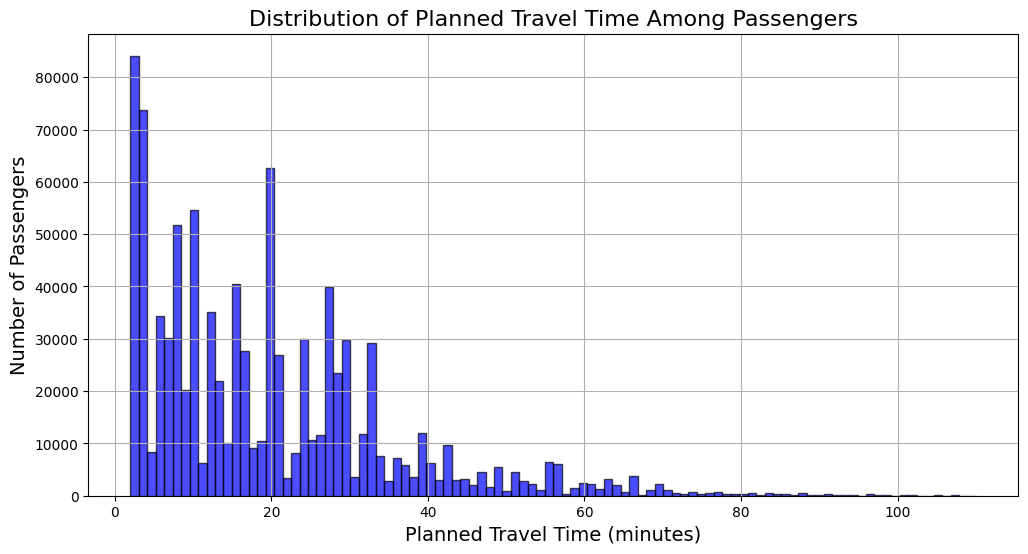

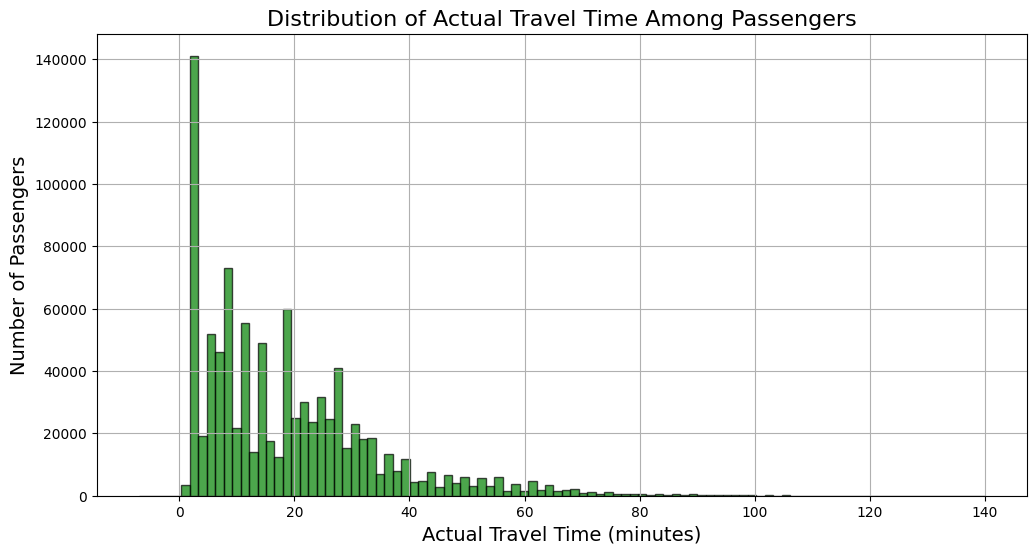

In [8]:
import matplotlib.pyplot as plt

# Plot 1: Distribution of planned travel time among passengers
plt.figure(figsize=(12, 6))

plt.hist(df_travel_times_actual['scheduled_travel_time'], bins=100, weights=df_travel_times_actual['n_passengers'], alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Planned Travel Time (minutes)', fontsize=14)
plt.ylabel('Number of Passengers', fontsize=14)
plt.title('Distribution of Planned Travel Time Among Passengers', fontsize=16)
plt.grid(True)
plt.show()

# Plot 2: Distribution of actual travel time among passengers
plt.figure(figsize=(12, 6))

plt.hist(df_travel_times_actual['actual_travel_time'], bins=100, weights=df_travel_times_actual['n_passengers'], alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Actual Travel Time (minutes)', fontsize=14)
plt.ylabel('Number of Passengers', fontsize=14)
plt.title('Distribution of Actual Travel Time Among Passengers', fontsize=16)
plt.grid(True)
plt.show()

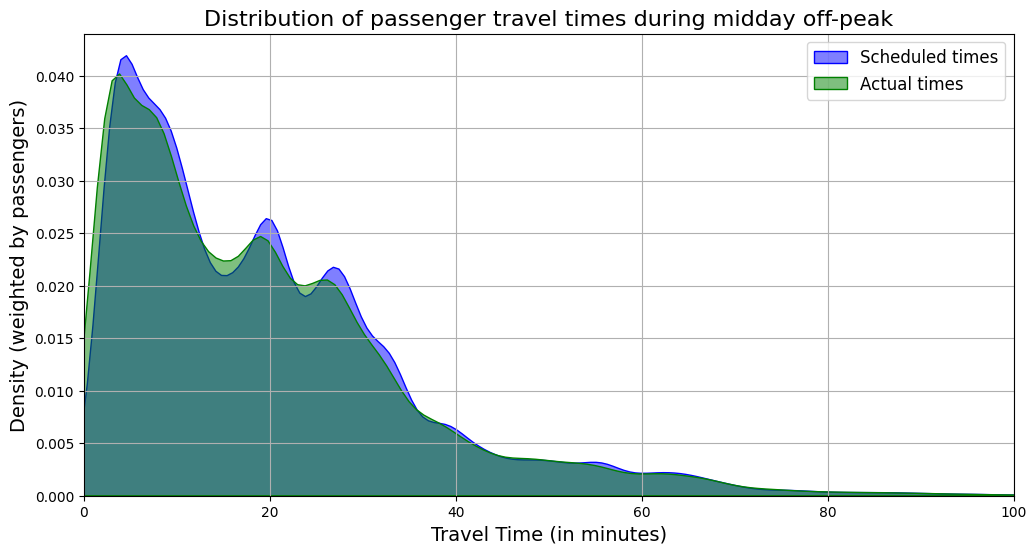

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot KDE for planned travel time distribution
sns.kdeplot(data=df_travel_times_actual, x='scheduled_travel_time', weights='n_passengers', color='blue', fill=True, alpha=0.5, label='Scheduled times')

# Plot KDE for actual travel time distribution
sns.kdeplot(data=df_travel_times_actual, x='actual_travel_time', weights='n_passengers', color='green', fill=True, alpha=0.5, label='Actual times')

# Add labels and title
plt.xlabel('Travel Time (in minutes)', fontsize=14)
plt.ylabel('Density (weighted by passengers)', fontsize=14)
plt.title('Distribution of passenger travel times during midday off-peak', fontsize=16)

# Add a legend
plt.legend(loc='upper right', fontsize=12)

# Display the grid
plt.grid(True)

# Set x-axis limits
plt.xlim(0, 100)

# Show the plot
plt.show()


### Travel time percentile

We are going now to study the journey time percentiles. For that we look at one Origin Destination (OD) example and plot the actual travel time percentile on the x-axis and travel time in minutes on the y-axis.
We will also plot the line horizontal line corresponding to the average planned travel time on that OD pair.

In [10]:
# Group by Origin-Destination pairs and sum the number of passengers
od_ridership = df_travel_times_actual.groupby(['Fran_platssignatur', 'Till_platssignatur'])['n_passengers'].sum().reset_index()

# Sort the OD pairs by ridership in descending order
od_ridership_sorted = od_ridership.sort_values(by='n_passengers', ascending=False)

# Get the top two OD pairs with the highest ridership
top_two_od_pairs = od_ridership_sorted.head(2)

# Display the top two OD pairs
print(top_two_od_pairs)


    Fran_platssignatur Till_platssignatur  n_passengers
471                Sst                Cst  36938.590907
95                 Cst                Sst  36222.997495


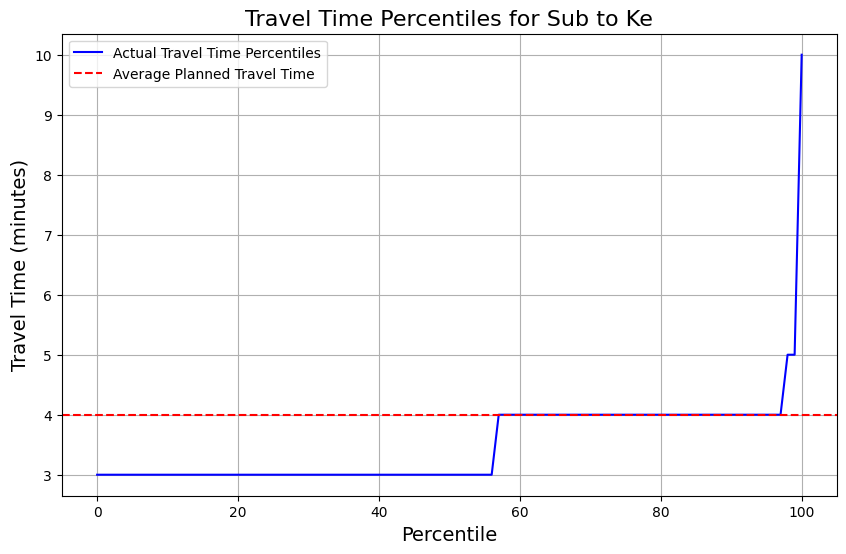

In [11]:
# Select a specific OD pair (replace 'Origin' and 'Destination' with actual station codes)
origin = 'Sub'
destination = 'Ke'

# Filter data for the selected OD pair
df_od_actual = df_travel_times_actual[(df_travel_times_actual['Fran_platssignatur'] == origin) & 
                                      (df_travel_times_actual['Till_platssignatur'] == destination)]

# Calculate the percentiles of actual travel time
percentiles = np.percentile(df_od_actual['actual_travel_time'], np.arange(0, 101, 1))

# Calculate the average planned travel time
avg_planned_travel_time = df_od_actual['scheduled_travel_time'].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the percentiles of actual travel time
plt.plot(np.arange(0, 101, 1), percentiles, label='Actual Travel Time Percentiles', color='blue')

# Plot the average planned travel time as a horizontal line
plt.axhline(y=avg_planned_travel_time, color='red', linestyle='--', label='Average Planned Travel Time')

# Add labels and title
plt.xlabel('Percentile', fontsize=14)
plt.ylabel('Travel Time (minutes)', fontsize=14)
plt.title(f'Travel Time Percentiles for {origin} to {destination}', fontsize=16)

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


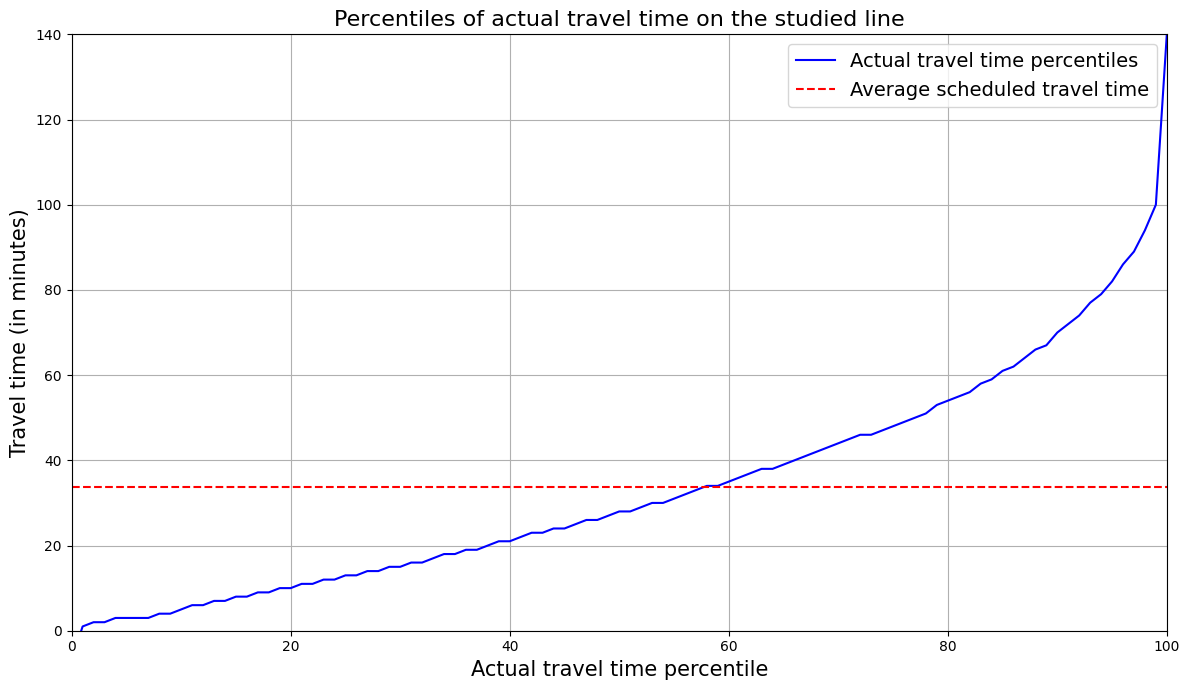

Average scheduled travel time: 33.80 minutes
Median Actual Travel Time: 28.00 minutes
90th Percentile Actual Travel Time: 70.00 minutes


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate percentiles of actual travel time across all OD pairs
all_actual_travel_times = df_travel_times_actual['actual_travel_time'].values
percentiles = np.percentile(all_actual_travel_times, np.arange(0, 101, 1))

# Calculate the average planned travel time across all OD pairs
avg_planned_travel_time = df_travel_times_actual['scheduled_travel_time'].mean()

# Plotting
plt.figure(figsize=(12, 7))

# Plot the percentiles of actual travel time
plt.plot(np.arange(0, 101, 1), percentiles, label='Actual travel time percentiles', color='blue')

# Plot the average planned travel time as a horizontal line
plt.axhline(y=avg_planned_travel_time, color='red', linestyle='--', label='Average scheduled travel time')

# Add labels and title
plt.xlabel('Actual travel time percentile', fontsize=15)
plt.ylabel('Travel time (in minutes)', fontsize=15)
plt.title('Percentiles of actual travel time on the studied line', fontsize=16)

# Add legend
plt.legend(fontsize=14)
plt.xlim(0,100)
plt.ylim(0,140)
# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Average scheduled travel time: {avg_planned_travel_time:.2f} minutes")
print(f"Median Actual Travel Time: {percentiles[50]:.2f} minutes")
print(f"90th Percentile Actual Travel Time: {percentiles[90]:.2f} minutes")

### Calculation of Excess Journey Time (EJT)

We will first calculate the average Excess Journey Time (EJT) per OD-pair. For a given OD-pair, EJT on a certain train trip is the positive difference between actual travel time and scheduled travel time, i.e., it is zero when scheduled travel time is longer than actual travel time. The average EJT of a given OD-pair is the sum of EJT for all individual train trips divided by the total number of trips, average over all the trips.

In [13]:
# Step 1: Calculate the mean scheduled travel time for each OD pair
df_travel_times_actual['mean_scheduled_travel_time'] = df_travel_times_actual.groupby(
    ['Fran_platssignatur', 'Till_platssignatur']
)['scheduled_travel_time'].transform('mean')

# Step 2: Calculate the Excess Journey Time (EJT) for each trip using the OD pair's mean scheduled travel time
df_travel_times_actual['EJT'] = (
    df_travel_times_actual['actual_travel_time'] - df_travel_times_actual['mean_scheduled_travel_time']
).clip(lower=0)

# Step 3: Group by Origin-Destination (OD) pairs and calculate the total EJT and the number of trips
od_ejt_summary = df_travel_times_actual.groupby(['Fran_platssignatur', 'Till_platssignatur']).agg(
    total_ejt=('EJT', 'sum'),
    total_trips=('EJT', 'count')
).reset_index()

# Step 4: Calculate the average EJT per OD-pair
od_ejt_summary['average_ejt'] = od_ejt_summary['total_ejt'] / od_ejt_summary['total_trips']

# Step 5: Display the summary
print(od_ejt_summary)


    Fran_platssignatur Till_platssignatur  total_ejt  total_trips  average_ejt
0                  Bkb                Bro       11.0          308     0.035714
1                  Bkb                Bål       14.0          308     0.045455
2                  Bkb                Cst      222.0          836     0.265550
3                  Bkb                Fas      199.0          666     0.298799
4                  Bkb                Gdv      445.0          309     1.440129
..                 ...                ...        ...          ...          ...
697                Öso                 Ts       17.0          309     0.055016
698                Öso                Tåd       28.0          309     0.090615
699                Öso                Vhe       48.0          309     0.155340
700                Öso                 Äs       75.0          309     0.242718
701                Öso                Åbe      113.0          309     0.365696

[702 rows x 5 columns]


We plot these average EJTs as a heatmap between the different pairs of stations on the studied line.

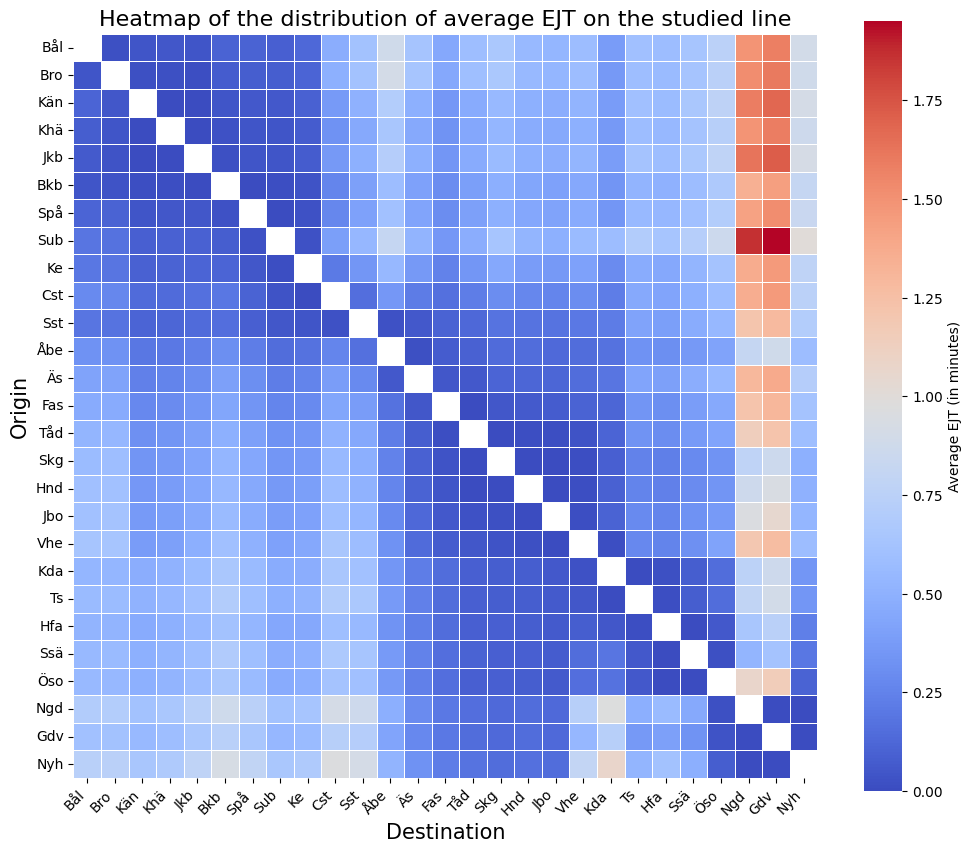

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming od_ejt_summary is already calculated

# List of stations from south to north
stations_south_to_north = ['Bål', 'Bro', 'Kän', 'Khä', 'Jkb', 'Bkb', 'Spå', 'Sub', 'Ke', 'Cst', 'Sst', 'Åbe', 'Äs',
                           'Fas', 'Tåd', 'Skg', 'Hnd', 'Jbo', 'Vhe', 'Kda', 'Ts', 'Hfa', 'Ssä', 'Öso', 'Ngd', 'Gdv', 'Nyh']

# Pivot table to create a matrix of average EJT with stations as rows and columns
heatmap_data = od_ejt_summary.pivot_table(index='Fran_platssignatur', columns='Till_platssignatur', values='average_ejt')

# Ensure the matrix includes all stations (even if some OD pairs have no data)
heatmap_data = heatmap_data.reindex(index=stations_south_to_north, columns=stations_south_to_north)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.5, square=True, cbar_kws={'label': 'Average EJT (in minutes)'})
plt.title('Heatmap of the distribution of average EJT on the studied line', fontsize=16)
plt.xlabel('Destination', fontsize=15)
plt.ylabel('Origin', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

The previous heatmap does not consider n_passengers, i.e., unweighted average EJTs per OD-pair. Now, we gonna plot a similar heatmap showing passenger-weighted average EJTs.

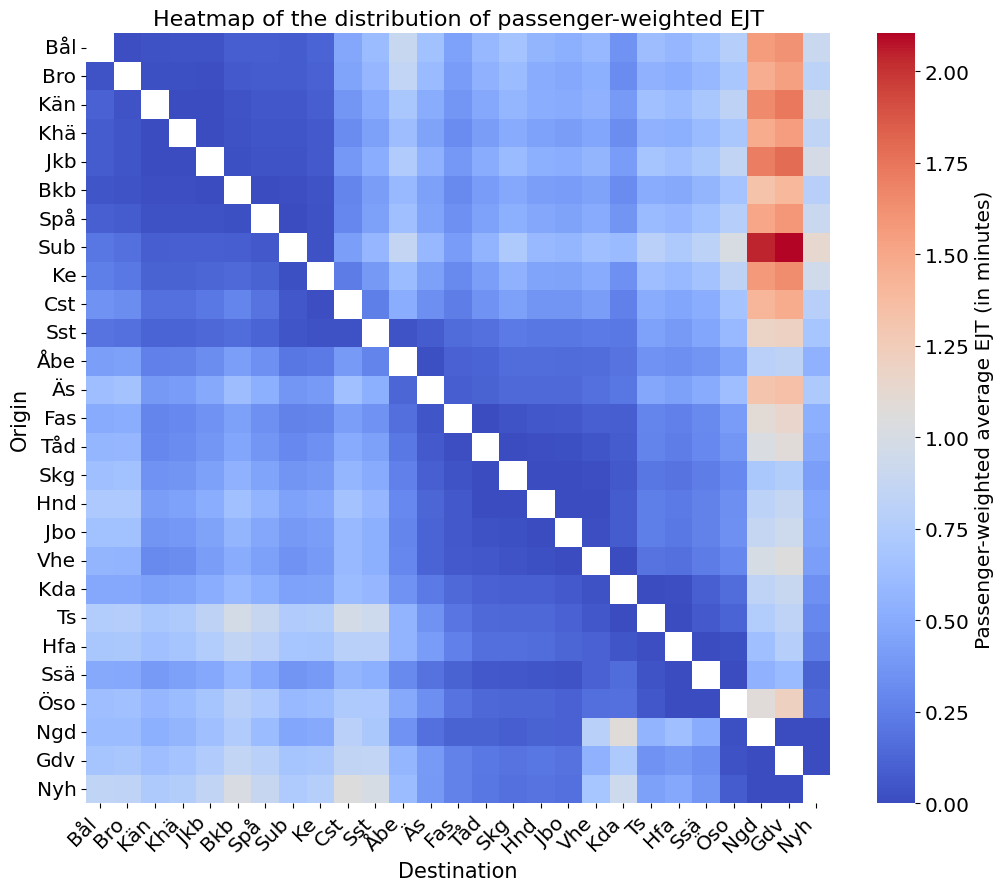

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Step 3: Compute the weighted EJT for each journey
df_travel_times_actual['weighted_ejt'] = df_travel_times_actual['EJT'] * df_travel_times_actual['n_passengers']

# Step 4: Aggregate weighted EJTs and total passengers by OD-pair
weighted_ejt_sum = df_travel_times_actual.groupby(['Fran_platssignatur', 'Till_platssignatur']).agg({
    'weighted_ejt': 'sum',
    'n_passengers': 'sum'
}).reset_index()

# Step 5: Calculate the passenger-weighted average EJT for each OD pair
weighted_ejt_sum['passenger_weighted_avg_ejt'] = weighted_ejt_sum['weighted_ejt'] / weighted_ejt_sum['n_passengers']

# Step 4: Pivot the data to create a matrix for the heatmap
heatmap_data = weighted_ejt_sum.pivot_table(index='Fran_platssignatur', columns='Till_platssignatur', values='passenger_weighted_avg_ejt', aggfunc='mean')

# Sort stations according to the order from south to north
heatmap_data = heatmap_data.reindex(index=stations_south_to_north, columns=stations_south_to_north)

# Plot the heatmap
plt.rcParams['font.size'] = 14.5  # Set global font size
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=False, cmap='coolwarm', linewidths=.0, linecolor='white', cbar_kws={'label': 'Passenger-weighted average EJT (in minutes)'})
plt.title('Heatmap of the distribution of passenger-weighted EJT', fontsize=16)
plt.xlabel('Destination', fontsize=15)
plt.ylabel('Origin', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


Now, we will calculate the average EJT across all the OD-pairs of the studied line by using the n_passengers traveling on the OD-pair as weights.

In [16]:
import numpy as np

# Assuming df_travel_times_actual has already been processed to include 'EJT' and 'n_passengers'

# Step 1: Calculate the weighted EJT for each OD-pair
df_travel_times_actual['weighted_ejt'] = df_travel_times_actual['EJT'] * df_travel_times_actual['n_passengers']

# Step 2: Sum up the total weighted EJT across all OD pairs
total_weighted_ejt = df_travel_times_actual['weighted_ejt'].sum()

# Step 3: Sum up the total number of passengers across all OD pairs
total_passengers = df_travel_times_actual['n_passengers'].sum()

# Step 4: Calculate the weighted average EJT across all OD pairs
weighted_average_ejt = total_weighted_ejt / total_passengers

# Step 5: Display the result
print(f"The weighted average EJT across all OD-pairs is: {weighted_average_ejt:.2f} minutes")


The weighted average EJT across all OD-pairs is: 0.32 minutes


### OTP and PP2 metrics at 3-min delay threshold

To compare with the weighted average EJT across all OD-pairs, we calculate the OTP and PP2 scores at 3-min delay threshold (in percent).

In [20]:
# Set the delay threshold to 3 minutes
delay_threshold = 3

# Count total passengers and arrivals for the offpeak period
total_pax_arrivals = df_onboard_actual_offpeak['n_alighting_next'].sum()
total_num_arrivals = len(df_onboard_actual_offpeak[(df_onboard_actual_offpeak['UppehallstypAnkomst'] == "Sista") 
                             & (df_onboard_actual_offpeak['Ankomsttid'].notna())])

# Calculate number of arrivals within 3-minute threshold
num_within_threshold = np.sum((df_onboard_actual_offpeak['arr_delay_minutes'] <= delay_threshold)
                              & (df_onboard_actual_offpeak['UppehallstypAnkomst'] == "Sista")
                              & (df_onboard_actual_offpeak['Ankomsttid'].notna()))

# Calculate OTP percentage for the 3-minute threshold
OTP_3min_percentage = (num_within_threshold / total_num_arrivals) * 100 if total_num_arrivals > 0 else 0

# Calculate passengers within the 3-minute threshold
pax_within_threshold = df_onboard_actual_offpeak[(df_onboard_actual_offpeak["arr_delay_minutes"] <= delay_threshold)
                                                 & (df_onboard_actual_offpeak['Ankomsttid'].notna())]['n_alighting_next'].sum()

# Calculate PP2 percentage for the 3-minute threshold
PP2_3min_percentage = (pax_within_threshold / total_pax_arrivals) * 100 if total_pax_arrivals > 0 else 0

# Display the results
print(f"OTP at 3-minute threshold (Off-peak): {OTP_3min_percentage:.2f}%")
print(f"PP2 at 3-minute threshold (Off-peak): {PP2_3min_percentage:.2f}%")

OTP at 3-minute threshold (Off-peak): 95.41%
PP2 at 3-minute threshold (Off-peak): 92.42%


We could also plot heatmaps for all OD-pairs to visualize the scores of OTP and PP2 for different pairs.

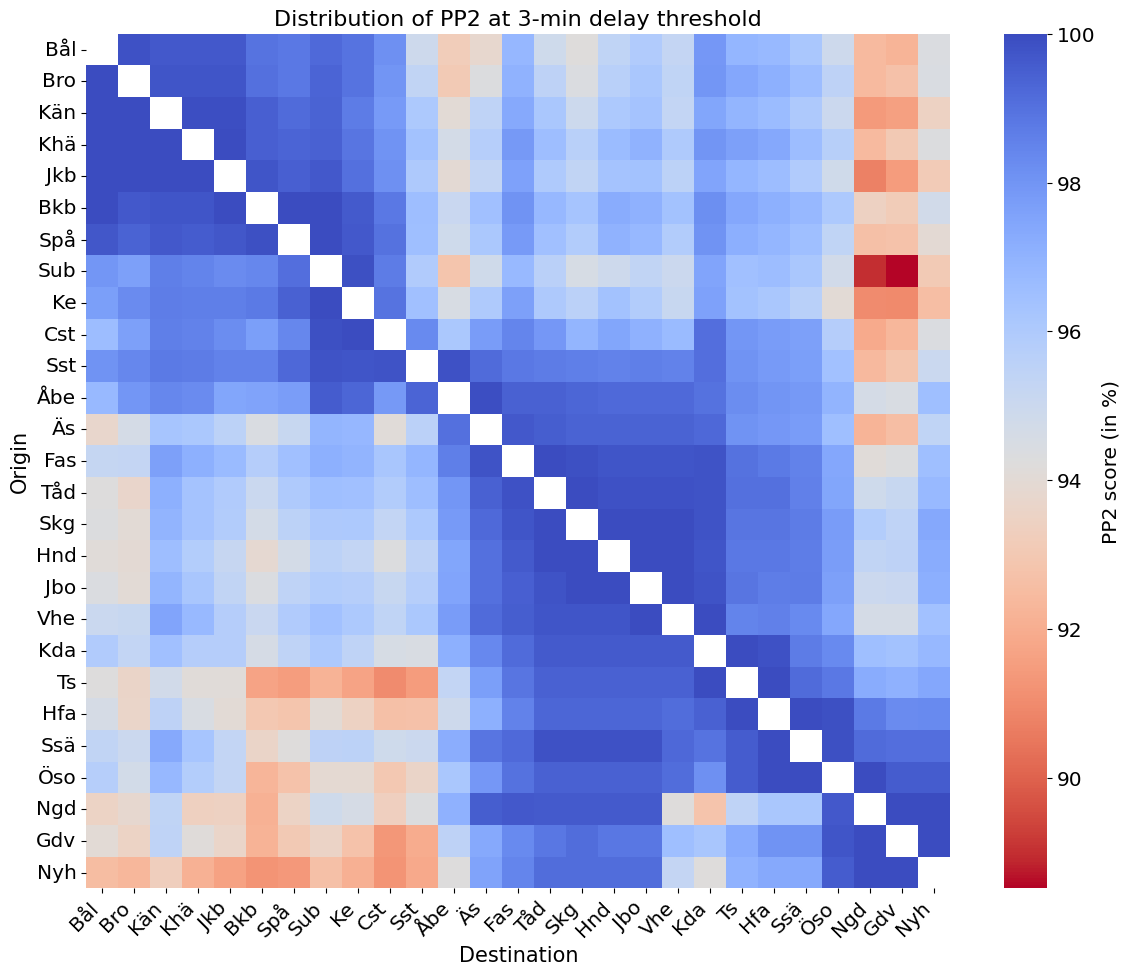

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the delay threshold
delay_threshold = 3  # minutes

# Step 1: Calculate PP2 for each OD-pair

# Function to calculate PP2 for an OD-pair
def calculate_pp2(df):
    total_passengers = df['n_passengers'].sum()
    passengers_within_threshold = df[df['actual_travel_time'] - df['scheduled_travel_time'] <= delay_threshold]['n_passengers'].sum()
    PP2 = (passengers_within_threshold / total_passengers) * 100 if total_passengers > 0 else 0
    return PP2

# Group by OD-pairs and calculate PP2
pp2_by_od = df_travel_times_actual.groupby(['Fran_platssignatur', 'Till_platssignatur']).apply(calculate_pp2,include_groups=False)

# Convert the results to a DataFrame
pp2_df = pd.DataFrame(pp2_by_od, columns=['PP2_3min']).reset_index()

# Step 2: Pivot the data to create a matrix for the heatmap
pp2_heatmap_data = pp2_df.pivot_table(index='Fran_platssignatur', columns='Till_platssignatur', values='PP2_3min')

# Sort stations according to the order from south to north
pp2_heatmap_data = pp2_heatmap_data.reindex(index=stations_south_to_north, columns=stations_south_to_north)

# Step 3: Plot the heatmap for PP2

plt.figure(figsize=(12, 10))

# Heatmap for PP2
plt.rcParams['font.size'] = 14.5  # Set global font size
sns.heatmap(pp2_heatmap_data, cmap='coolwarm_r', annot=False, fmt=".1f", cbar_kws={'label': 'PP2 score (in %)'})
plt.title('Distribution of PP2 at 3-min delay threshold', fontsize=16)
plt.xlabel('Destination', fontsize=15)
plt.ylabel('Origin', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


### PP2 versus average EJT (scatter plot)

Now that we have calculated average EJTs and PP2 for different OD-pairs. It can be interesting to plot them together in a scatter plot. Different points correspond to different OD-pairs.

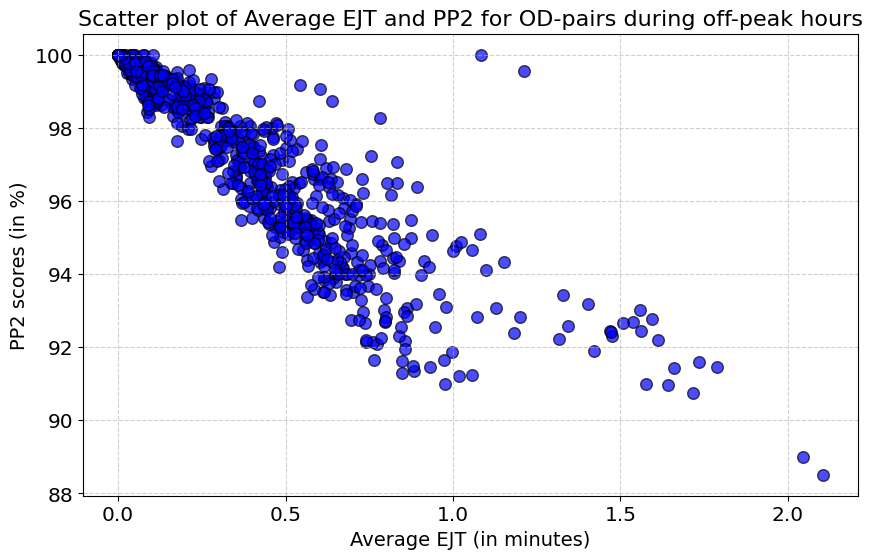

In [19]:
import matplotlib.pyplot as plt

# Prepare the data for the scatter plot
scatter_data = weighted_ejt_sum[['passenger_weighted_avg_ejt']].copy()

# Reset index to align with scatter_data
scatter_data['PP2_3min'] = pp2_by_od.reset_index(drop=True)

# Drop any OD-pairs with missing data (optional, depending on your data quality)
scatter_data = scatter_data.dropna()

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot the scatter plot with enhanced readability
plt.scatter(scatter_data['passenger_weighted_avg_ejt'], scatter_data['PP2_3min'], 
            color='blue', alpha=0.7, edgecolor='k', s=70)  # Adding edgecolor and adjusting point size

# Add labels and title with increased font size for better readability
plt.xlabel('Average EJT (in minutes)', fontsize=14)
plt.ylabel('PP2 scores (in %)', fontsize=14)
plt.title('Scatter plot of Average EJT and PP2 for OD-pairs during off-peak hours', fontsize=16)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()
